# SynMall-synScore Analysis Script

1. This script is used to reproduce the analysis of the SynMall paper
2. You have to download the data first through the `download.sh` to perform the reproduce.

# 1 Retrieve sSNVs in ACMG actionable genes

In [ ]:
# load packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import textwrap
from adjustText import adjust_text
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator

In [3]:
print("[INFO] Loading data and merge... ")
df_synScore = pd.read_csv("../Result/whole_genome/synScore.whole.genome.txt", sep='\t', low_memory=False)
df_acmg_ssnv = pd.read_csv("../Data/Analysis/ACMG_actions_synonymous_variants.txt", sep='\t')
df_acmg_ssnv = df_acmg_ssnv.merge(df_synScore, how='left', left_on='Variant38', right_on='Variant38', suffixes=('', '_m'))

[INFO] Loading data and merge... 


/tmp/ipykernel_620688/1717890896.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_acmg_ssnv = pd.read_csv("../Data/Analysis/ACMG_actions_synonymous_variants.txt", sep='\t')


# 2 Deduplicate for every gene

Some genes may overlap, so we deduplicate inner genes.

In [4]:
df_acmg_ssnv_dedup = pd.DataFrame()
print(f"[INFO] Before: {len(df_acmg_ssnv)}")
grouped = df_acmg_ssnv.groupby("gene_name")
for _, tdf in grouped:
    tdf.drop_duplicates(subset=['Variant38'], inplace=True)
    df_acmg_ssnv_dedup = pd.concat([df_acmg_ssnv_dedup, tdf], ignore_index=True)
print(f"[INFO] After: {len(df_acmg_ssnv_dedup)}")

[INFO] Before: 237298
[INFO] After: 236125


In [5]:
# Save results
df_acmg_ssnv_dedup.to_csv("../Data/Analysis/ACMG_actions_synonymous_variants_synScores.txt", sep='\t', index=False)

In [22]:
# Top potential deleterious sSNVs in actionable genes
df_acmg_ssnv_dedup.sort_values(by='synScore', ascending=False)

,transcript_id,cds_pos,chr,pos_38,ref,alt,source,Variant38,codon_alt,gene_name,synScore
94476,ENST00000355349,768,14,23431446,T,A,G&C&S&F,14_23431446_T/A,GGA/GGT,MYH7,0.925989
91595,ENST00000300036,2229,16,15747895,C,A,G&C&S&F,16_15747895_C/A,GGG/GGT,MYH11,0.925965
121675,ENST00000359596,5988,19,38490249,C,T,G&C&S&F,19_38490249_C/T,CGC/CGT,RYR1,0.925676
120775,ENST00000359596,4698,19,38483104,G,T,G&C&S&F,19_38483104_G/T,GGG/GGT,RYR1,0.925655
150216,ENST00000344887,24,19,55157296,C,T,G&C&S&F,19_55157296_C/T,GCG/GCA,TNNI3,0.925362
...,...,...,...,...,...,...,...,...,...,...,...
41151,ENST00000304636,2430,2,189002336,T,C,G&C&S&F,2_189002336_T/C,GGT/GGC,COL3A1,0.171259
133932,ENST00000366574,8889,1,237678106,T,C,G&C&S&F,1_237678106_T/C,TTT/TTC,RYR2,0.171164
64038,ENST00000325888,5244,7,128850020,A,G,G&C&S&F,7_128850020_A/G,CCA/CCG,FLNC,0.171090
234266,ENST00000237014,45,18,31591947,A,G,G&C&S&F,18_31591947_A/G,GTA/GTG,TTR,0.171057


# 3 synScore in actionable genes

## 3.1 Calculate Median/Mean/Min/Max for every gene

In [8]:
grouped = df_acmg_ssnv_dedup.groupby("gene_name")["synScore"]
group_stats = grouped.describe()
group_stats

,count,mean,std,min,25%,50%,75%,max
gene_name,,,,,,,,
ACTA2,770.0,0.320272,0.175348,0.174732,0.234496,0.251915,0.324296,0.924409
ACTC1,782.0,0.251678,0.085043,0.176628,0.218695,0.233682,0.262246,0.923941
ACVRL1,1095.0,0.262893,0.113905,0.175079,0.215910,0.232027,0.256115,0.924265
APC,5639.0,0.245868,0.073461,0.175632,0.222139,0.237004,0.255714,0.924749
APOB,9054.0,0.244100,0.064742,0.175142,0.224456,0.239313,0.253220,0.923723
...,...,...,...,...,...,...,...,...
TSC2,3975.0,0.257126,0.112844,0.173521,0.206272,0.229147,0.252602,0.923434
TTN,73976.0,0.256122,0.084579,0.172767,0.227114,0.240064,0.260960,0.925109
TTR,332.0,0.248502,0.089534,0.171057,0.214371,0.241097,0.256416,0.891764


## 3.2 Statistical Testing

1. Calculate the median or mean of the global score distribution as a reference baseline.
2. Differential testing for each gene versus the entire set (or versus other genes).

In [9]:
global_median = df_acmg_ssnv_dedup['synScore'].median()
global_mean = df_acmg_ssnv_dedup['synScore'].mean()
print(f"[INFO] Global median: {global_median}")
print(f"[INFO] Global mean: {global_mean}")

[INFO] Global median: 0.2374415218266764
[INFO] Global mean: 0.25787326346254685


## 3.3 Mann-Whitney U Test

1. Obtain the scores on the given gene and the scores of other genes.
2. Calculate deleterious enrichment and benign enrichment (whether the scores on the given gene are significantly higher or significantly lower than those of other genes).
3. Perform `Bonferroni multiple testing correction` for statistical significance.

In [ ]:
results = []
df = df_acmg_ssnv_dedup.copy()
for gene, group_df in df.groupby("gene_name"):
    scores = group_df["synScore"]
    others = df[df["gene_name"] != gene]["synScore"]
    stat, pval = mannwhitneyu(scores, others, alternative='greater')  # deleterious enrichment
    stat2, pval2 = mannwhitneyu(scores, others, alternative='less')   # benign enrichment
    results.append({
        "gene": gene,
        "mean": scores.mean(),
        "median": scores.median(),
        "count": len(scores),
        "pval_harmful": pval,
        "pval_benign": pval2
    })
res_df = pd.DataFrame(results)
res_df["adj_p_harmful"] = res_df["pval_harmful"] * len(res_df)  # Bonferroni
res_df["adj_p_benign"] = res_df["pval_benign"] * len(res_df)


## 3.4 Volcano Plot Enrichment Analysis

1. Replace p-values of 0 with a very small value (1e-300) to prevent calculation errors in logarithmic operations.
2. Calculate the negative log10 of pval_harmful—higher values now indicate stronger statistical significance.
3. Identify significant genes with a corrected adj_p_harmful less than 0.05.
4. Mark genes with adj_p_harmful < 0.05 in gray.
5. For genes with adj_p_harmful > 0.05:
   - Mark those with a mean greater than the median mean in red.
   - Mark those with a mean less than the median mean in blue.
6. On the plot, genes closer to the top-right corner are more likely to be enriched for deleterious synonymous mutations.

In [11]:
acmg_gene_df = pd.read_csv("../Data/Analysis/ACMG_actions.csv", usecols=['Gene', 'Phenotype Category'])
acmg_gene_df.rename(columns={'Gene': 'gene'}, inplace=True)
# SMAD4 has two categories, here we use the cancer category
acmg_gene_df = acmg_gene_df[~((acmg_gene_df['gene'] == 'SMAD4') & (acmg_gene_df['Phenotype Category'] == 'Miscellaneous'))]
acmg_gene_df.drop_duplicates(inplace=True)
res_df_with_pheno = res_df.merge(acmg_gene_df, how='left', left_on='gene', right_on='gene', suffixes=('', '_Bonobos'))
res_df_with_pheno['Phenotype Category'].value_counts()

Phenotype Category
Cardiovascular               39
Cancer                       28
Miscellaneous                 9
Metabolic                     3
Cardiovascular\nMetabolic     2
Name: count, dtype: int64

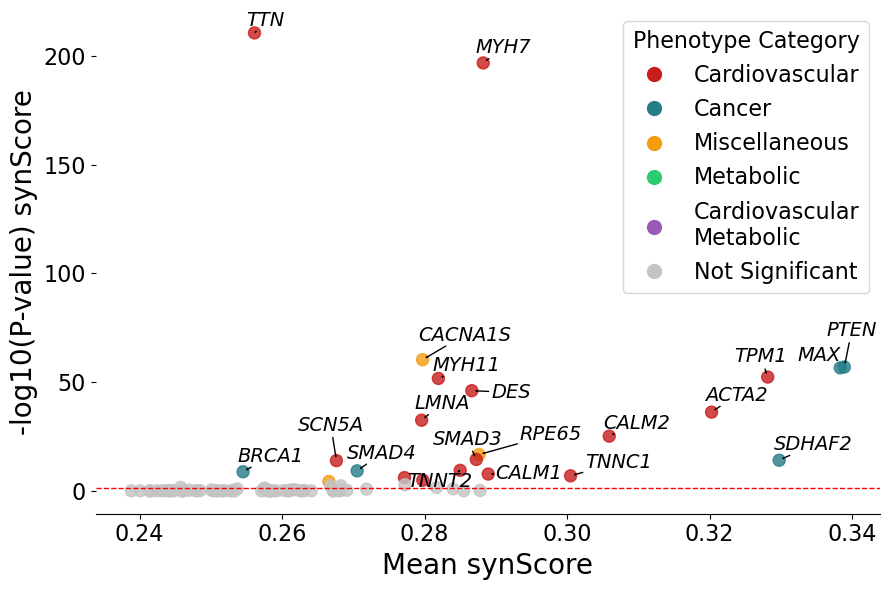

In [ ]:
# Visualize
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Pre-process data
res_df_with_pheno["pval_harmful"] = res_df_with_pheno["pval_harmful"].replace(0, 1e-300)
res_df_with_pheno["log_p"] = -np.log10(res_df_with_pheno["pval_harmful"])

# Identify significant genes
res_df_with_pheno["significant"] = res_df_with_pheno["adj_p_harmful"] < 0.05
  
category_colors = {
    "Cardiovascular": "#c71e1d",
    "Cancer": "#267c87",
    "Miscellaneous": "#f39c12",
    "Metabolic": "#2ecc71",
    "Cardiovascular\nMetabolic": "#9b59b6"
}
def get_color(row):
    if not row["significant"]:
        return "#c4c4c4"
    return category_colors.get(row["Phenotype Category"], "#000000")  # fallback color

res_df_with_pheno["color"] = res_df_with_pheno.apply(get_color, axis=1)

# Create plot
plt.figure(figsize=(9, 6))
plt.scatter(res_df_with_pheno["mean"], res_df_with_pheno["log_p"], c=res_df_with_pheno["color"], alpha=0.8, s=75)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1) # Significance threshold line
plt.ylabel("-log10(P-value) synScore", fontsize=20)
plt.xlabel("Mean synScore", fontsize=20)

# Remove top, right, and left spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Increase tick label sizes
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

# Select top 20 most significant genes for labeling
sig_df = res_df_with_pheno[res_df_with_pheno["significant"]].sort_values("log_p", ascending=False).head(20)

# Add gene name annotations
texts = []
for _, row in sig_df.iterrows():
    texts.append(plt.text(row["mean"], row["log_p"], row["gene"], 
                   fontsize=14, ha='center', va='bottom', fontstyle='italic'))

from matplotlib.lines import Line2D

# Create circular legend elements (for significant categories)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=12)
    for label, color in category_colors.items()
]
# Add non-significant gray point
legend_elements.append(
    Line2D([0], [0], marker='o', color='w', label='Not Significant',
           markerfacecolor="#c4c4c4", markersize=12)
)
# Add legend
plt.legend(handles=legend_elements, title="Phenotype Category", fontsize=16,
           title_fontsize=16, loc='upper right', frameon=True)

# Automatically adjust text to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=1))
plt.tight_layout()
# plt.savefig("../Result/plot/synScore.volcano.plot.jpg", dpi=300, bbox_inches='tight')
plt.show()

## 3.5 CDS Distribution

1. In this section, we examine the synScore distribution of synonymous mutations within actionable genes, focusing on splice site consensus regions and internal exons.  
2. From Section 3.4, we observed that most genes have low synScores for synonymous mutations. Since **TTN** is considered an actionable gene only for `truncating variants`, it is excluded from this analysis.  
3. The genes **MYH7**, **PTEN**, **MAX**, and **TPM1** show relatively higher mean synScores and statistical significance; therefore, we conducted further analyses on synonymous mutations within these genes.


In [ ]:
# 1 loading transcript information
transcript_canonical_df = pd.read_csv("../Data/Analysis/gene_information_canonical.txt", sep='\t')

In [ ]:
def plot_splice_site_analysis(gene_name, exon_info):
    region_color = '#c71e1d' # '#d71b82' #be5022
    dot_color = '#15607a'
    df = df_acmg_ssnv_dedup[df_acmg_ssnv_dedup['gene_name'] == gene_name]
    transcript_id = df.iloc[0]['transcript_id']
    exon_row = exon_info[exon_info['transcript_id'] == transcript_id]
    if exon_row.empty:
        raise ValueError(f"{transcript_id} not found in exon_info")

    starts = np.array([int(x) for x in exon_row.iloc[0]['cds_start'].split(';')])
    ends = np.array([int(x) for x in exon_row.iloc[0]['cds_end'].split(';')])

    consensus_positions = set()
    for s in starts:
        consensus_positions.update(range(s, s + 2)) 
    for e in ends:
        consensus_positions.update(range(e - 3, e + 1))  

    df["is_consensus"] = df["cds_pos"].isin(consensus_positions)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df["cds_pos"], df["synScore"], color=dot_color, s=9, alpha=0.5, label="Other")

    for s in starts:
        ax.axvspan(s, s + 1, color=region_color, alpha=0.3)
    for e in ends:
        ax.axvspan(e - 3, e, color=region_color, alpha=0.3)

    ax.set_ylim(0, df["synScore"].max() * 1.1)

    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False) 

    # Configure ticks
    ax.tick_params(axis='x', which='both', direction='out', length=6, width=1.5, labelsize=16)
    ax.tick_params(axis='y', which='both', direction='out', length=6, width=1.5, labelsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlabel("Coding Sequence", fontsize=18)
    ax.set_ylabel("synScore", fontsize=18)
    ax.set_title(
        f"synScore Distribution on $\\it{{{gene_name}}}$", 
        fontsize=18, 
        pad=40
    )
    # Compute
    group1 = df[df["is_consensus"]]["synScore"]
    group2 = df[~df["is_consensus"]]["synScore"]
    stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')

    # Custom legend items
    legend_labels = {
        f"Splice Site Consensus ($\\it{{p}}$ = {pval:.2e})": region_color, 
    }
    # Create patch objects for legend
    custom_patches = [mpatches.Patch(color=color, label=label)
                    for label, color in legend_labels.items()]
    plt.legend(
        handles=custom_patches,
        bbox_to_anchor=(0.2, 0.98), 
        fontsize=16,
        frameon=True,
        facecolor='white',
        edgecolor='none',
        framealpha=0.8
    )
    plt.tight_layout()
    plt.savefig(f"../Result/plot/synScore_splice_site_consensus_{gene_name}.jpg", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"[Statistical Results] Two-sided consensus region vs non-consensus region:")
    print(f"- Sample sizes: {len(group1)} vs {len(group2)}")
    print(f"- Mann-Whitney U test p = {pval:.4g}")
    return df

### *MYH7*

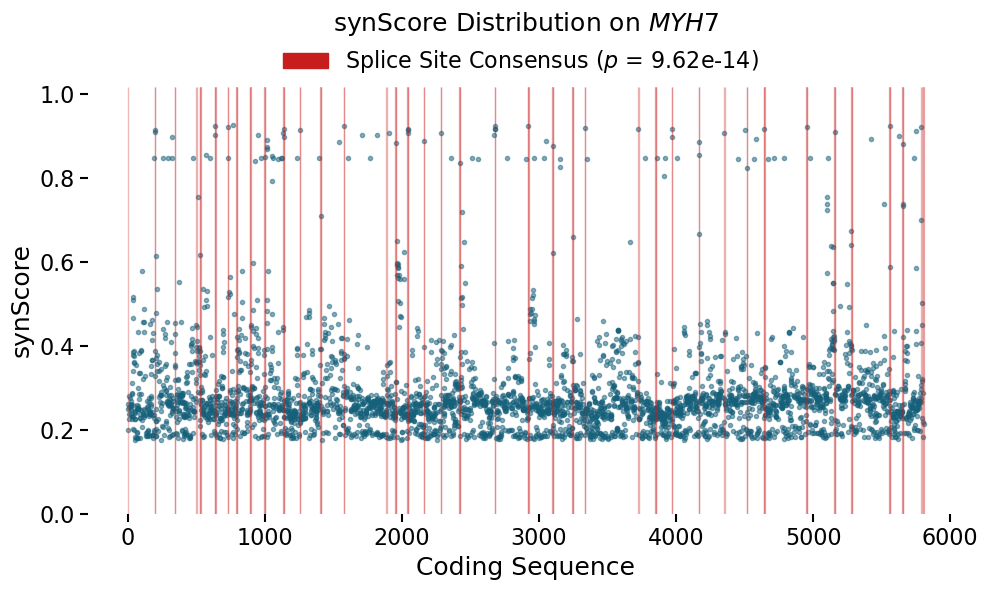

[Statistical Results] Two-sided consensus region vs non-consensus region:
- Sample sizes: 133 vs 3672
- Mann-Whitney U test p = 9.621e-14


In [209]:
result_df = plot_splice_site_analysis('MYH7', transcript_canonical_df)

### *PTEN*

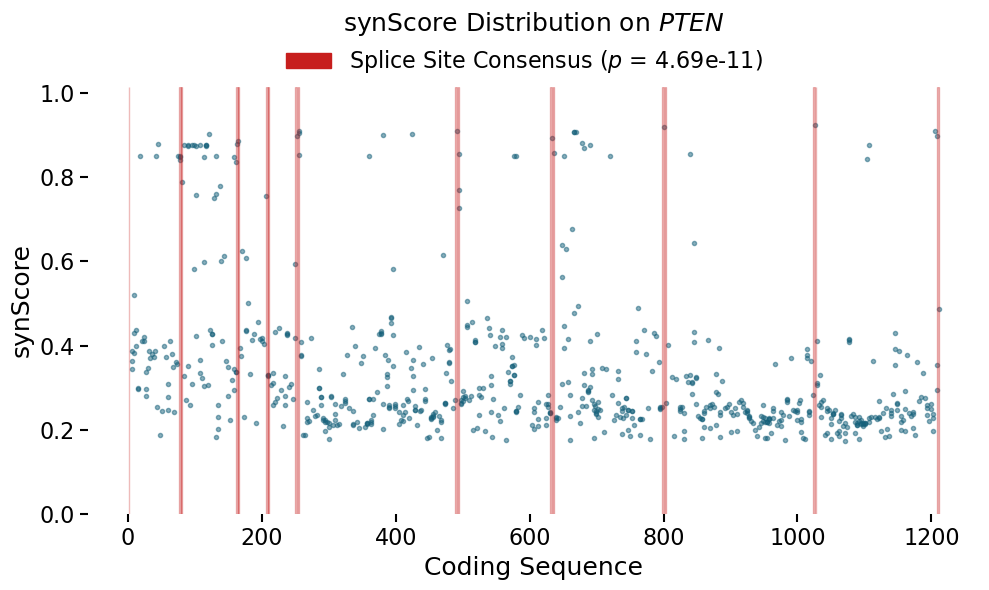

[Statistical Results] Two-sided consensus region vs non-consensus region:
- Sample sizes: 30 vs 692
- Mann-Whitney U test p = 4.69e-11


In [221]:
result_df = plot_splice_site_analysis('PTEN', transcript_canonical_df)

### *CACNA1S*

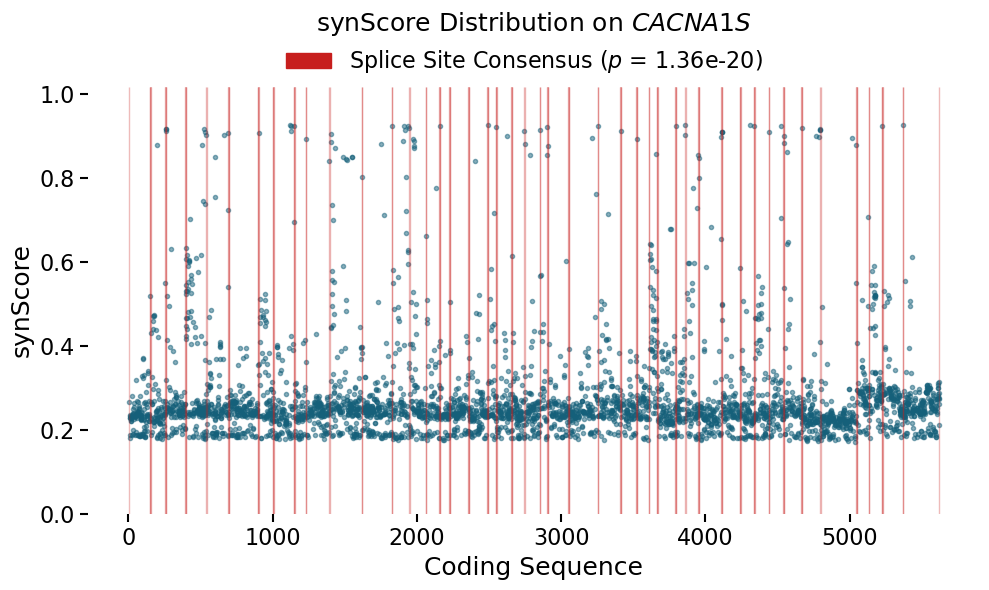

[Statistical Results] Two-sided consensus region vs non-consensus region:
- Sample sizes: 153 vs 3703
- Mann-Whitney U test p = 1.362e-20


In [222]:
result_df = plot_splice_site_analysis('CACNA1S', transcript_canonical_df)

### *MAX*

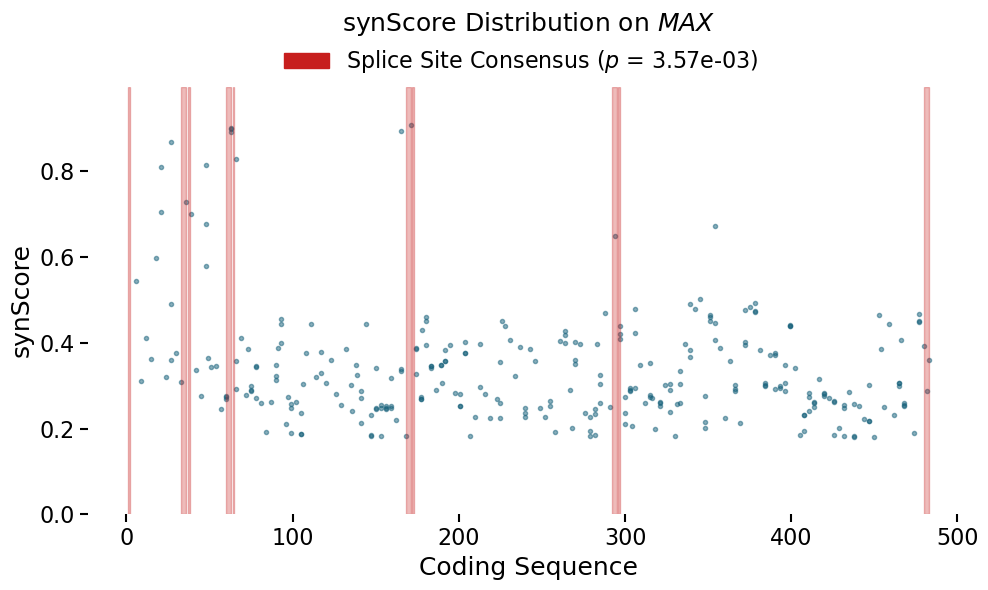

[Statistical Results] Two-sided consensus region vs non-consensus region:
- Sample sizes: 17 vs 290
- Mann-Whitney U test p = 0.00357


In [225]:
result_df = plot_splice_site_analysis('MAX', transcript_canonical_df)

### *TPM1*

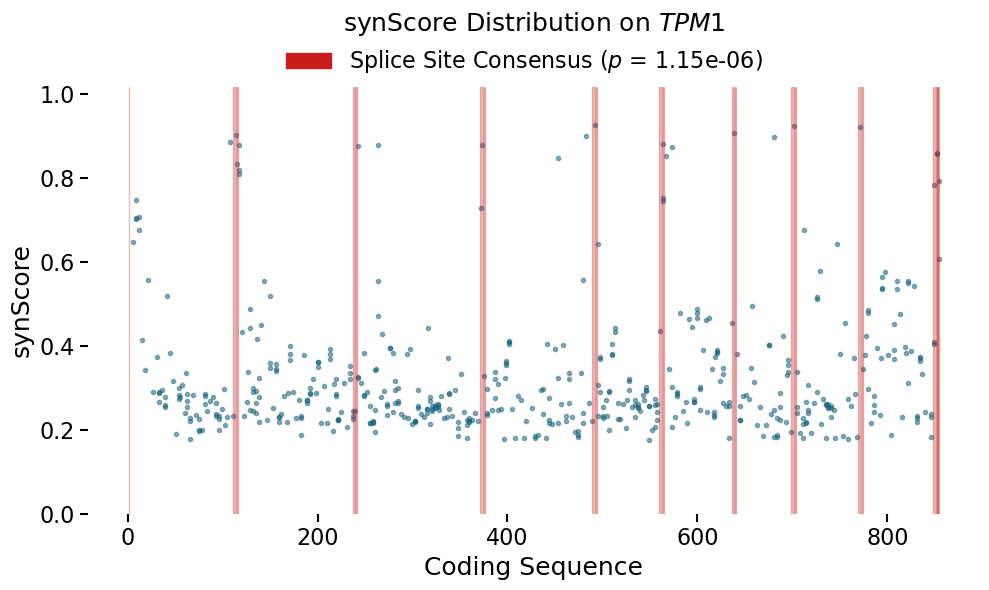

[Statistical Results] Two-sided consensus region vs non-consensus region:
- Sample sizes: 29 vs 500
- Mann-Whitney U test p = 1.15e-06


In [223]:
result_df = plot_splice_site_analysis('TPM1', transcript_canonical_df)

### *MYH11*

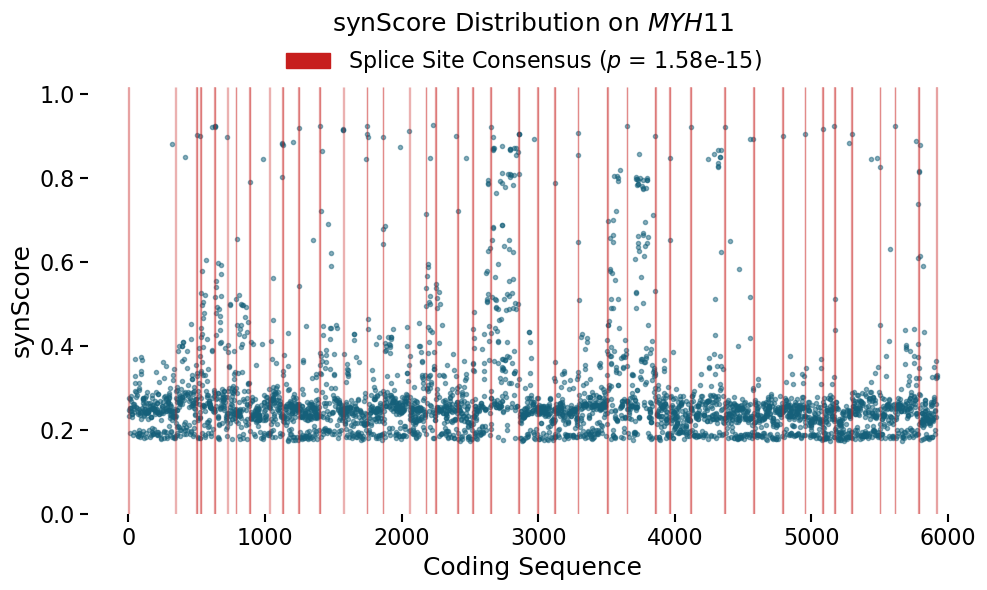

[Statistical Results] Two-sided consensus region vs non-consensus region:
- Sample sizes: 149 vs 3682
- Mann-Whitney U test p = 1.58e-15


In [224]:
result_df = plot_splice_site_analysis('MYH11', transcript_canonical_df)

## 3.6 InterPro

Distribution of sSNVs on protein functional domains.
Conducted through https://www.ebi.ac.uk/interpro/

In [ ]:
# 1 retrieve amino acids
gene_list = ['MYH7', 'PTEN', 'CACNA1S', 'MAX', 'TPM1', 'MYH11']
for gene_name in gene_list:
    ip_df = df_acmg_ssnv_dedup[df_acmg_ssnv_dedup['gene_name'] == gene_name]
    tid = ip_df.iloc[0]['transcript_id']
    aa_seq = transcript_canonical_df[transcript_canonical_df['transcript_id'] == tid].iloc[0]['amino_acids']
    print(f">{gene_name}")
    print(aa_seq)

>MYH7
MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEFVKAKIVSREGGKVTAETEYGKTVTVKEDQVMQQNPPKFDKIEDMAMLTFLHEPAVLYNLKDRYGSWMIYTYSGLFCVTVNPYKWLPVYTPEVVAAYRGKKRSEAPPHIFSISDNAYQYMLTDRENQSILITGESGAGKTVNTKRVIQYFAVIAAIGDRSKKDQSPGKGTLEDQIIQANPALEAFGNAKTVRNDNSSRFGKFIRIHFGATGKLASADIETYLLEKSRVIFQLKAERDYHIFYQILSNKKPELLDMLLITNNPYDYAFISQGETTVASIDDAEELMATDNAFDVLGFTSEEKNSMYKLTGAIMHFGNMKFKLKQREEQAEPDGTEEADKSAYLMGLNSADLLKGLCHPRVKVGNEYVTKGQNVQQVIYATGALAKAVYERMFNWMVTRINATLETKQPRQYFIGVLDIAGFEIFDFNSFEQLCINFTNEKLQQFFNHHMFVLEQEEYKKEGIEWTFIDFGMDLQACIDLIEKPMGIMSILEEECMFPKATDMTFKAKLFDNHLGKSANFQKPRNIKGKPEAHFSLIHYAGIVDYNIIGWLQKNKDPLNETVVGLYQKSSLKLLSTLFANYAGADAPIEKGKGKAKKGSSFQTVSALHRENLNKLMTNLRSTHPHFVRCIIPNETKSPGVMDNPLVMHQLRCNGVLEGIRICRKGFPNRILYGDFRQRYRILNPAAIPEGQFIDSRKGAEKLLSSLDIDHNQYKFGHTKVFFKAGLLGLLEEMRDERLSRIITRIQAQSRGVLARMEYKKLLERRDSLLVIQWNIRAFMGVKNWPWMKLYFKIKPLLKSAEREKEMASMKEEFTRLKEALEKSEARRKELEEKMVSLLQEKNDLQLQVQAEQDNLADAEERCDQLIKNKIQLEAKVKEMNERLEDEEEMNAELTAKKRKLEDECSELKRDIDDLELTLAKVEKEKHATENKVKNLTEEMAGLDEIIAKLTK

In [ ]:
# 2 Go to InterPro for annotation (condunct on the InterPro website)
cols = [
    "seq_id", "md5", "length", "database", "entry_id", "entry_desc",
    "start", "end", "evalue", "status", "date", 
    "ipr_id", "ipr_desc", "GO", "Pathway"
]
interpro = pd.read_csv(f"../Data/Analysis/InterPro.tsv", sep='\t', names=cols)

In [ ]:
# 3 Visualize
def draw_interpro(interpro, gene_name, show_legend=False):
    # clean interpro entry desc
    interpro = interpro[interpro['seq_id'] == gene_name]
    interpro = interpro[interpro['entry_desc'] != '-'].copy()
    interpro['entry_desc'] = interpro['entry_desc'].str.rstrip('.')
    interpro['entry_desc_wrapped'] = interpro['entry_desc'].apply(lambda x: textwrap.fill(x, width=20))

    # retrieve aa pos
    ip_df = df_acmg_ssnv_dedup[df_acmg_ssnv_dedup['gene_name'] ==  gene_name]
    ip_df['aa_pos'] = (ip_df['cds_pos'] - 1) // 3 + 1
    threshold = 0.5
    draw_df = ip_df[ip_df["synScore"] > threshold].copy()

    # filter interpro with sSNVs harbored regions
    aa_positions = set(draw_df["aa_pos"].tolist())
    interpro = interpro[interpro.apply(lambda row: any(pos >= row["start"] and pos <= row["end"] for pos in aa_positions), axis=1)].reset_index(drop=True)

    # plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # the higher the synScore is, the deeper the color
    stem_colors = [
        (0.9, '#d34c39'), 
        (0.8, '#df6a54'), 
        (0.7, '#e98670'), 
        (0.6, '#f2a18d'), 
        (0.5, '#fabcac')
    ]

    # draw lollipop
    for _, row in draw_df.iterrows():
        score = row["synScore"]
        pos = row["aa_pos"]
        color = '#cccccc'  # default grey
        for threshold, c in stem_colors:
            if score > threshold:
                color = c
                break
        ax.vlines(pos, 0, score, color=color, alpha=0.7)
        ax.plot(pos, score, 'o', color=color, markersize=5)

    # draw functional domains
    unique_domains = interpro['entry_desc_wrapped'].unique().tolist()
    colors = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)
    domain2color = {dom: colors[i % len(colors)] for i, dom in enumerate(unique_domains)}

    used_labels = set()
    for i, (_, row) in enumerate(interpro.iterrows()):
        x0 = row["start"]
        width = row["end"] - row["start"] + 1
        y_base = -0.05 - 0.04 * (i % 8)
        label = row["entry_desc_wrapped"]
        color = domain2color[label]
        # legend 
        label_to_plot = label if label not in used_labels else None
        used_labels.add(label)

        rect = patches.Rectangle(
            (x0, y_base), width, 0.03, linewidth=1,
            edgecolor='#333', facecolor=color, label=label_to_plot
        )
        ax.add_patch(rect)

    # prettier
    ax.set_xlabel("Amino Acid Sequence", fontsize=16)
    max_stack_layer = interpro.shape[0] if interpro.shape[0] < 8 else 8
    ymin = -0.05 - 0.04 * (max_stack_layer - 1) - 0.02
    ax.set_ylim(ymin, draw_df["synScore"].max() * 1.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    ax.set_title(
        f"sSNVs with high predicted synScore in $\\it{{{gene_name}}}$", 
        fontsize=18, 
    )

    plt.tight_layout()
    plt.show()

    if show_legend:
        fig_legend, ax_legend = plt.subplots(figsize=(4, 6))
        handles, labels = ax.get_legend_handles_labels()
        unique = dict()
        for h, l in zip(handles, labels):
            if l not in unique and l != '':
                # handle underline and line break
                clean_label = l.replace('\n', ' ').replace('_', '-')
                # the first letter of each word is capitalized, and the rest is lowercase
                clean_label = clean_label.strip().capitalize()
                # auto textwrap, with a maximum of 25 characters per line
                clean_label = textwrap.fill(clean_label, width=25)
                unique[l] = (h, clean_label)

        handles_clean = [v[0] for v in unique.values()]
        labels_clean = [v[1] for v in unique.values()]

        ax_legend.legend(
            handles_clean, labels_clean,
            fontsize=10,
            frameon=False,
            ncol=1,
            loc='center',
            mode='expand'
        )
        ax_legend.axis('off')
        plt.tight_layout()
        plt.show()


### *MYH7*

1. Coil

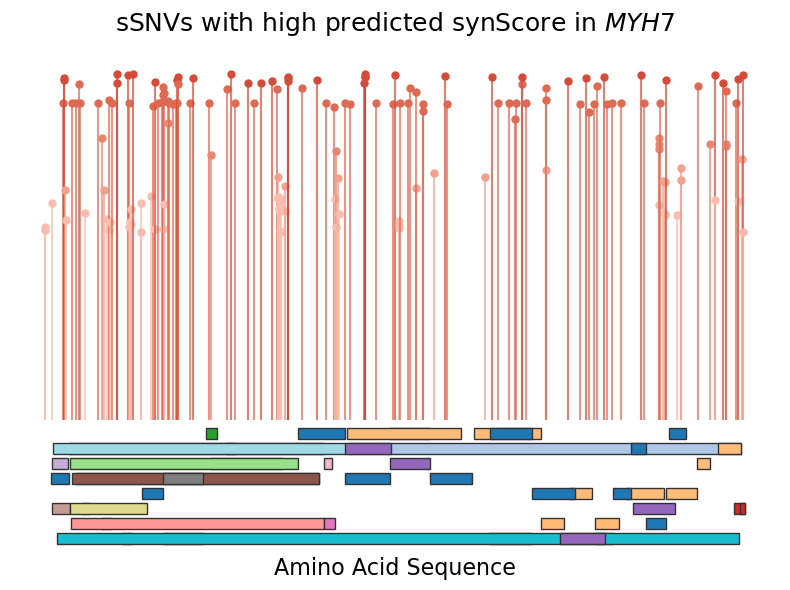

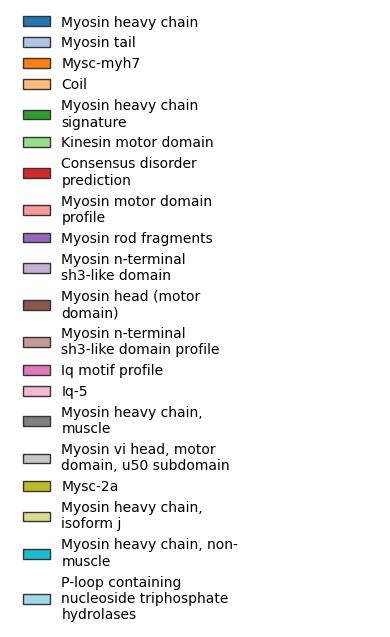

In [262]:
draw_interpro(interpro, "MYH7", show_legend=True)

### *PTEN*

1. Ptp-Phen
2. C2 domain
3. Ptp-7

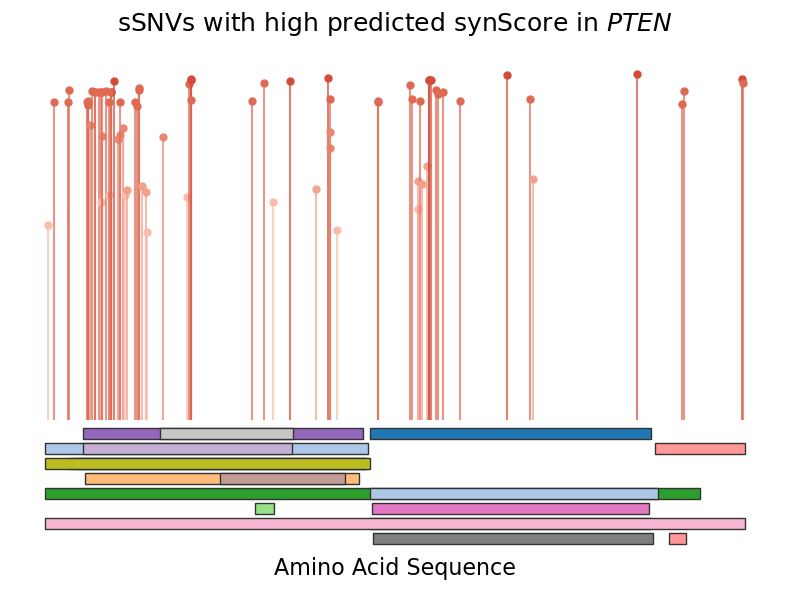

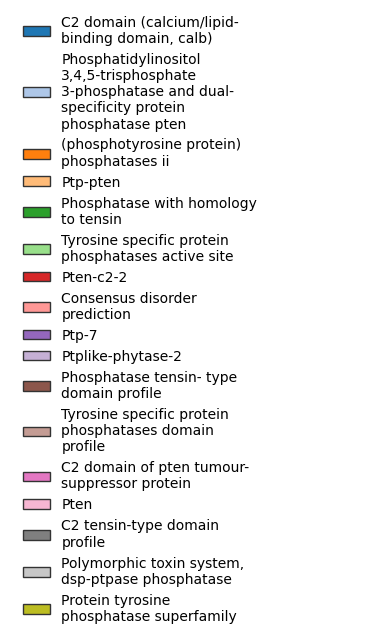

In [263]:
draw_interpro(interpro, "PTEN", show_legend=True)

### *CACNA1S*

1. region of a membrane bound protein predicted to be embedded in the membrane

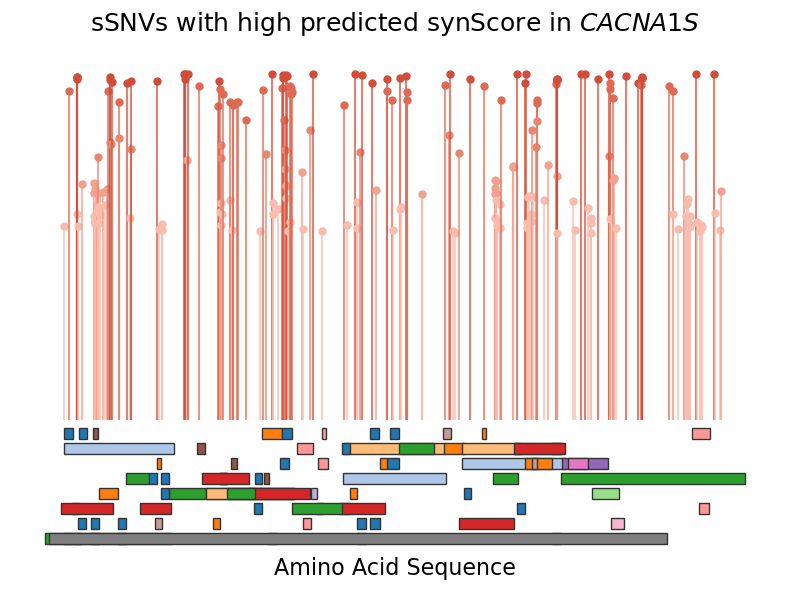

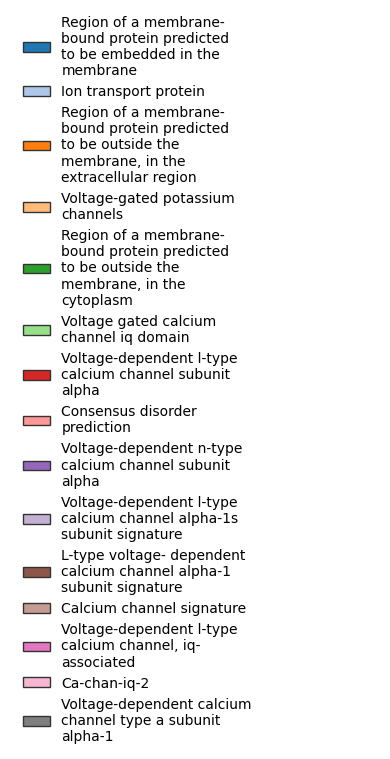

In [264]:
draw_interpro(interpro, "CACNA1S", show_legend=True)

### *TPM1*

1. Consensus disorder prediction
2. Coil

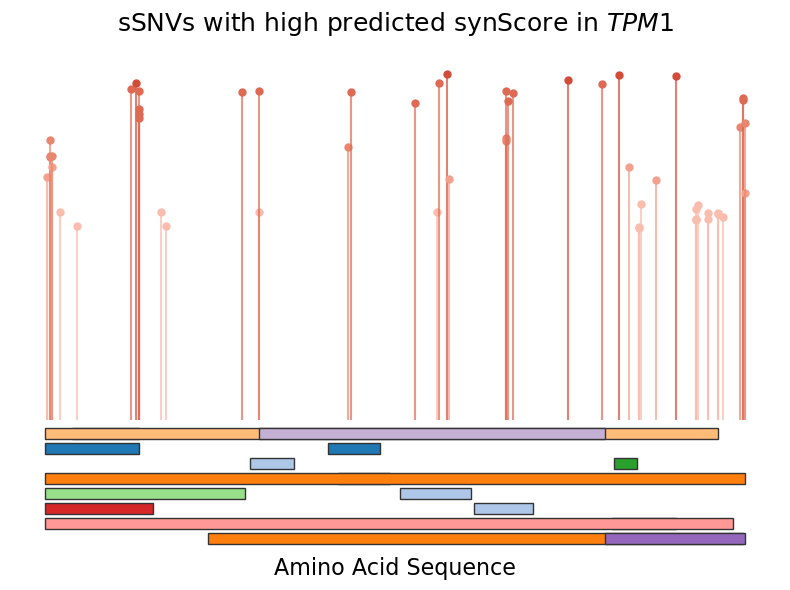

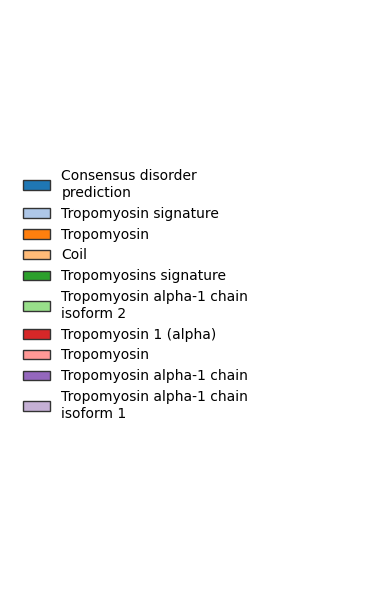

In [265]:
draw_interpro(interpro, "TPM1", show_legend=True)

### *MYH11*

1. Coil
2. Myosin rod fragments
3. Myosin-11 isoform x2

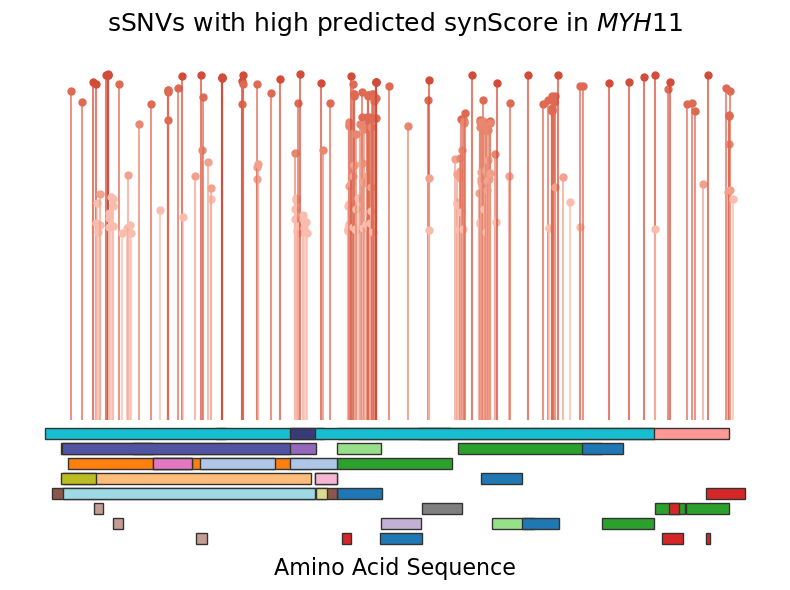

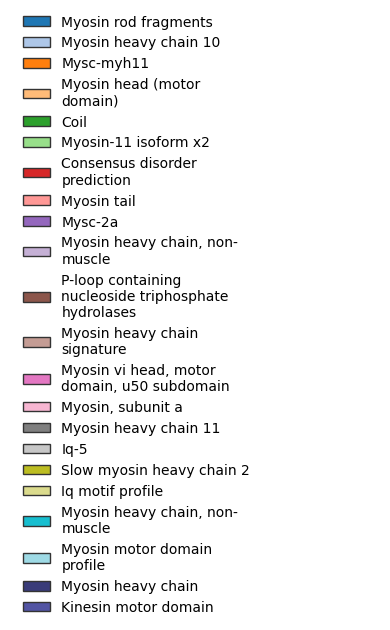

In [266]:
draw_interpro(interpro, "MYH11", show_legend=True)

### *MAX*

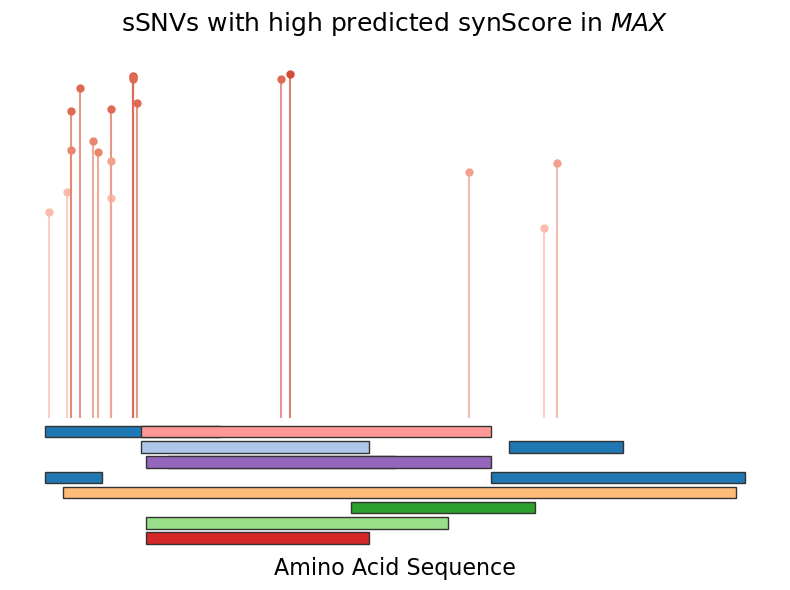

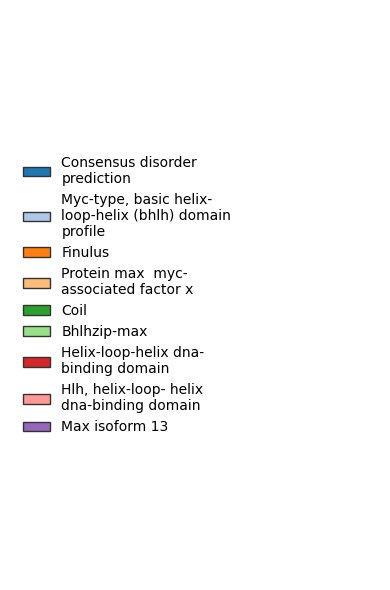

In [267]:
draw_interpro(interpro, "MAX", show_legend=True)

# 4 synScore vs. LoEUF

1. First, we calculated the proportion of high-score sSNVs across all genes.  
2. Next, we computed for each gene the expected (estimated based on the global proportion) and observed counts of high-score sSNVs.  
3. We then compared constrained and unconstrained genes, grouped by **LoEUF** using the recommended threshold of 0.6. Specifically, lower LoEUF values indicate genes that are more intolerant to loss of function, reflecting stronger evolutionary constraint.  
4. Here, “high-score” refers to potentially pathogenic synonymous mutations, defined using the `0.5 threshold` from our machine learning binary classification task.


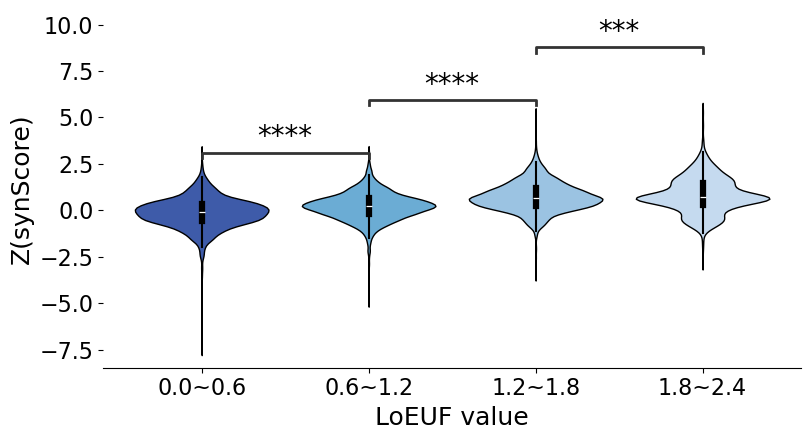

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

# 1. Load data
cons_ssnv_df = pd.read_csv("../Data/Analysis/gnomad.v4.1.constraint_sSNVs.txt", sep='\t')  
cons_gene_df = pd.read_csv("../Data/Analysis/gnomad.v4.1.constraint_genes.txt", sep='\t',
                           usecols=['transcript', 'lof.oe_ci.upper', 'mis.z_score', 'lof.pLI']) 

# 2. Concatenate transcript and sSNVs infos
summary_df = cons_ssnv_df.merge(df_synScore, on='Variant38', how='left') \
    .merge(cons_gene_df, left_on='transcript_id', right_on='transcript', how='left')

# 3. Count by transcripts
summary_df = summary_df.groupby('transcript_id').agg({
    'synScore': ['mean', 'median', 'max', 'count'],
    'lof.oe_ci.upper': 'first'
}).reset_index()
summary_df.columns = ['transcript_id', 'avg_score', 'med_score', 'max_score', 'mutation_count', 'loeuf']

# 4. Defined a threshold (here we used the common 0.5 threshold in machine learning binary classification tasks)
threshold = 0.5
summary_df['is_high'] = summary_df['max_score'] >= threshold

# 5. Calculate Observed and total sSNVs
gene_counts = summary_df.groupby('transcript_id').agg({
    'is_high': 'sum',          # Observed high-score sSNVs
    'mutation_count': 'sum'    # Total sSNVs
}).reset_index()
gene_counts.rename(columns={'is_high': 'observed_high', 'mutation_count': 'total_snvs'}, inplace=True)

# 6. Global high synScore proportion
p_high = summary_df['is_high'].sum() / summary_df['mutation_count'].sum()

# 7. Expected and SD (Based on binomial distribution)
gene_counts['expected_high'] = gene_counts['total_snvs'] * p_high
gene_counts['sd_high'] = np.sqrt(gene_counts['total_snvs'] * p_high * (1 - p_high))

# 8. Gene-level Z-score
gene_counts['z_score_gene'] = (gene_counts['observed_high'] - gene_counts['expected_high']) / gene_counts['sd_high']
summary_df = summary_df.merge(gene_counts[['transcript_id', 'z_score_gene']], on='transcript_id', how='left')

# 9. Group by LoEUF (<0.6 is a recommended threshold in https://gnomad.broadinstitute.org/news/2024-03-gnomad-v4-0-gene-constraint/)
loeuf_max = summary_df['loeuf'].max()
loeuf_min = summary_df['loeuf'].min()
bins = [loeuf_min, 0.6] + list(np.arange(1.2, loeuf_max + 0.6, 0.6))
labels = [f"{round(bins[i], 1)}~{round(bins[i+1], 1)}" for i in range(len(bins)-1)]
summary_df['loeuf_group'] = pd.cut(summary_df['loeuf'], bins=bins, labels=labels, include_lowest=True)

# 10. Visualize
plt.rcParams.update({'axes.labelsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16})
colors = ['#3e5ba9', '#6bacd4', '#9bc3e2', '#c5daef'] 
plt.figure(figsize=(8, 4.5))
ax = sns.violinplot(data=summary_df, 
                    x='loeuf_group', 
                    y='z_score_gene', 
                    inner='box', 
                    palette=colors,
                    saturation=1,
                    linewidth=1,
                    edgecolor='#000')

# Prettier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# 11. Significant annotation
pairs = list(zip(labels[:-1], labels[1:4])) 
annotator = Annotator(ax, pairs, data=summary_df, x='loeuf_group', y='z_score_gene')
annotator.configure(test='Mann-Whitney', 
                    text_format='star', 
                    loc='inside',
                    fontsize=20, 
                    line_width=2,
                    verbose=0,
                    line_height=0.02)
annotator.apply_and_annotate()
plt.xlabel("LoEUF value", fontsize=18)
plt.ylabel("Z(synScore)", fontsize=18)
plt.tight_layout()
plt.show()


# 5 synScore V.S. COSMIC

1. The sSNVs with top synScores in COSMIC and their gene enrichment.

In [33]:
cosmic_df = pd.read_csv("../Data/Analysis/COSMIC_v100.txt", sep='\t', usecols=['Variant38'])
cosmic_selected_df = cosmic_df.merge(df_synScore, how='left', left_on='Variant38', right_on='Variant38', suffixes=('', '_m'))

In [ ]:
cutoff = 0.001 # select the top 0.1%
extreme_high = cosmic_selected_df.sort_values(by='synScore', ascending=False).head(int(len(cosmic_selected_df) * cutoff))
extreme_high[['first_part', 'ALT']] = extreme_high['Variant38'].str.split('/', expand=True)
extreme_high[['#CHROM', 'POS', 'REF']] = extreme_high['first_part'].str.split('_', expand=True)
extreme_high.drop('first_part', axis=1, inplace=True)
extreme_high.to_csv("../Data/Analysis/COSMIC_v100_top.txt", sep='\t', index=False)

In [ ]:
def deduplicate(df):
    """
    Desc: 
        Deduplicate if multiple transcript records
        1. deduplicate based on columns: transcript_id|cds_pos|ref|alt|Variant38
        2. if remain duplicate values, select the longest source record (Supported by mulitple sources represent more more trustworthy)
    """
    return df.loc[df.groupby(['transcript_id', 'cds_pos', 'ref', 'alt', 'Variant38'])['source'].apply(lambda x: x.str.len().idxmax())].reset_index(drop=True)

trans_cancer = pd.read_csv("../Data/Analysis/COSMIC_v100_top_Transcript_Wise.csv")
trans_cancer_dedup = deduplicate(trans_cancer)
# select the canonical transcript infos transcript_canonical_df
trans_cancer_dedup = trans_cancer_dedup.merge(transcript_canonical_df, how='left', left_on='transcript_id', right_on='transcript_id', suffixes=('', '_m'))
trans_cancer_dedup = trans_cancer_dedup[trans_cancer_dedup['is_canonical'] == True].drop_duplicates(subset='Variant38')

[INFO] 去重前: 9380
[INFO] 去重后: 2345
[INFO] 读取经典转录本: 349


In [ ]:
# save result
df_enri_gene = pd.DataFrame({'gene_list': list(trans_cancer_dedup['gene_id'].value_counts().keys())})
df_enri_gene.to_csv("../Data/Analysis/COSMIC_v100_top_Genes.txt", sep='\t', index=False)

## 5.1 KEGG Pathway

The gene enrichment is conducted by [DAVID](https://david.ncifcrf.gov/).

In [ ]:
# loading data
pathway_df = pd.read_csv("../Data/Analysis/COSMIC_v100_KEGG.csv").iloc[:10]
pathway_df

,Category,Term,Genes,Count,List Total,Pop Hits,Pop Total,P-Value,Benjamini,Fold Enrichment,Bonferroni,FDR,Fisher Exact
0,KEGG_PATHWAY,Arrhythmogenic right ventricular cardiomyopathy,4.04%,13,169,86,8534,9.890000e-08,0.000018,7.63,0.000027,0.000017,1.130000e-08
1,KEGG_PATHWAY,Cytoskeleton in muscle cells,6.21%,20,169,232,8534,1.280000e-07,0.000018,4.35,0.000035,0.000017,2.720000e-08
2,KEGG_PATHWAY,Hypertrophic cardiomyopathy,3.73%,12,169,99,8534,3.500000e-06,0.000322,6.12,0.000965,0.000305,5.110000e-07
3,KEGG_PATHWAY,Regulation of actin cytoskeleton,4.66%,15,169,232,8534,1.860000e-04,0.011800,3.26,0.050000,0.011200,5.340000e-05
4,KEGG_PATHWAY,Dilated cardiomyopathy,3.11%,10,169,105,8534,2.140000e-04,0.011800,4.81,0.057200,0.011200,4.050000e-05
5,KEGG_PATHWAY,Focal adhesion,4.04%,13,169,203,8534,6.490000e-04,0.029900,3.23,0.164000,0.028300,1.880000e-04
6,KEGG_PATHWAY,Protein digestion and absorption,2.80%,9,169,105,8534,1.050000e-03,0.041500,4.33,0.252000,0.039400,2.230000e-04
7,KEGG_PATHWAY,Apelin signaling pathway,3.11%,10,169,140,8534,1.730000e-03,0.059800,3.61,0.380000,0.056700,4.450000e-04
8,KEGG_PATHWAY,AMPK signaling pathway,2.80%,9,169,122,8534,2.740000e-03,0.084100,3.73,0.532000,0.079900,6.800000e-04
9,KEGG_PATHWAY,Phosphatidylinositol signaling system,2.48%,8,169,98,8534,3.120000e-03,0.086000,4.12,0.577000,0.081600,6.940000e-04


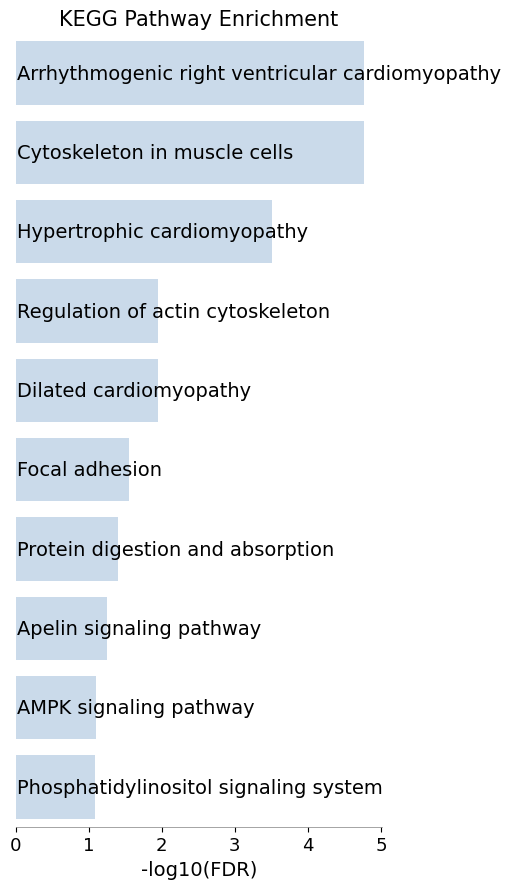

In [ ]:
kegg_draw_df = pathway_df.copy()
# process data
kegg_draw_df['-log10(FDR)'] = -np.log10(kegg_draw_df['FDR'])
kegg_draw_df = kegg_draw_df.sort_values('-log10(FDR)', ascending=False)

# draw
plt.figure(figsize=(5, 9))
bars = sns.barplot(data=kegg_draw_df, y='Term', x='-log10(FDR)', color='#c5daef')
plt.xlabel('-log10(FDR)', fontsize=14)  # set the font size of x axis
plt.ylabel('')  # clear y label axis
plt.title('KEGG Pathway Enrichment', fontsize=15)

# remove label tick labels of y axis
plt.yticks([])

# Add labels
for i, (_, row) in enumerate(kegg_draw_df.iterrows()):
    # 在条形内部右侧添加通路名称
    plt.text(0.02, i, row['Term'], 
             va='center', ha='left', fontsize=14,
             color='black', fontweight='normal')

# Prettier
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', labelsize=13, )
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('gray')

plt.tight_layout()
plt.show()